In [1]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

In [4]:
xs = np.arange(-5, 5, 0.25)

In [5]:
ys = f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

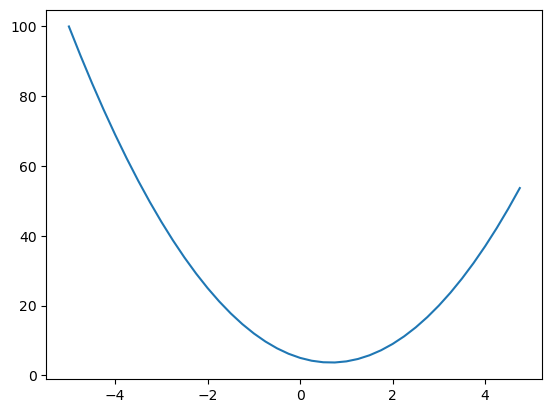

In [6]:
plt.plot(xs, ys)

In [7]:
h = 0.001
x = 3.0
(f(x+h) - f(x))/h

14.00300000000243

In [8]:
## complex cases

In [9]:
h = 0.0001
a = 2.0
b = -3.0
c = 10 
d1 = a*b + c

a+=h 
d2 = a*b +c

print('d1',d1)
print('d2',d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [111]:
class Value:
    def __init__(self, data, _children=(), _op="", label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None 
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self,other), '+')
        
        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward
        return out
        
    def __mul__(self, other): 
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad 
        
        out._backward = _backward
        return out
     
    def tanh(self):
        x = self.data 
        t = (math.exp(2*x) -1) /(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ),'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supportive int/float powers for now"
        out = Value(self.data ** other, (self,), f'**{other}')
        
        def _backward():
            self.grad += other * (self.data ** (other-1)) * out.grad
        out._backward = _backward
        return out
        
        
    def __rmul__(self, other):
        return self * other
    
    def __radd__(self, other):
        return self * other
    
    def __truediv__(self, other):
        return self * other **-1
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad= 1.0
        for node in reversed(topo):
            node._backward()
        
    
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'l'

L

Value(data=-8.0)

In [11]:
!pip install graphviz

In [12]:
from graphviz import Digraph

In [13]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
        for child in v._prev:
            edges.add((child, v))
            build(child)
    build(root)
    return nodes, edges

In [14]:
def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name= uid, label="{%s | data %.4f | grad %.4f}" % (n.label,n.data, n.grad ), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name= uid + n._op, label= n._op)
            #and connect this node to it 
            dot.edge(uid + n._op, uid)
            
    for n1, n2 in edges:
        # connect n1 to the op node of n2 
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

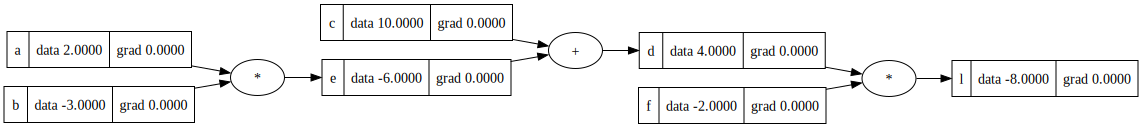

In [15]:
draw_dot(L)

In [16]:
# set up gradients by calculating manually
e.grad = -2.0
c.grad = -2.0

In [17]:
a.grad = (-2.0 * -3.0)
b.grad = -2.0 * 2.0


In [18]:
# L = d * f

# dL / dd = f

# f.grad = 4.0
# d.grad = -2


# dL/de = -2.0
# dL/da = (dL/de) * (de/da)


In [19]:
L.grad = 1.0

In [20]:
def lol():
    h  = 0.001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label = 'f')
    L = d * f; L.label = 'L'
    L1 = L.data
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    b.data += h
    
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L2 = L.data
    print((L2 - L1)/h)
    
lol()    

-3.9999999999995595


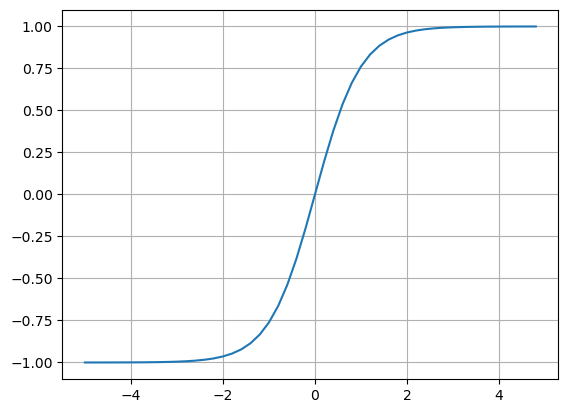

In [21]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [22]:
#inputs x1, x2
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label ='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias of the neuron
b = Value(6.7, label='b')
# x1 * w1 +x2*w2 +b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'


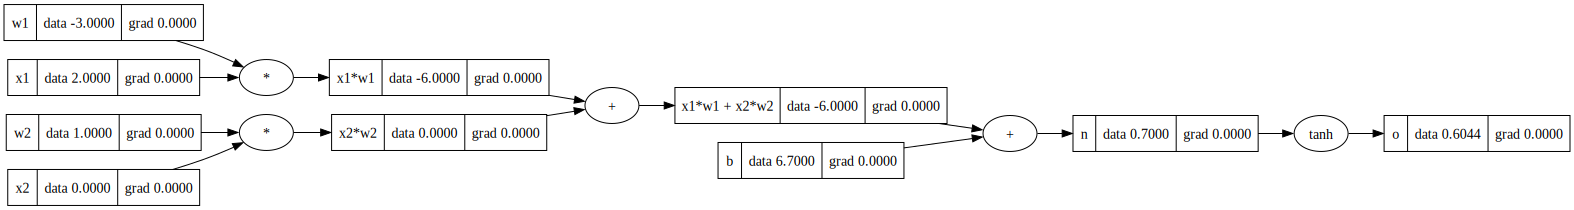

In [23]:
draw_dot(o)

In [24]:
## time stamp 1.00.00

In [25]:
o.grad = 1.0
o._backward()

In [26]:
n._backward()

In [27]:
b._backward()

In [28]:
x1w1x2w2._backward()

In [29]:
x2w2._backward()
x1w1._backward() 

In [30]:
##topological sort
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(data=6.7),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=0.7000000000000002),
 Value(data=0.6043677771171636)]

In [31]:
o.grad = 1.0
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)

for node in reversed(topo):
    node._backward()

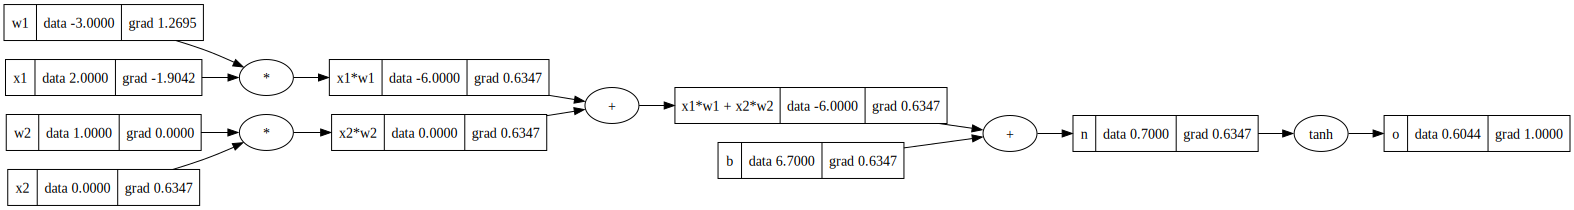

In [32]:
draw_dot(o)

In [33]:
o.backward()

In [34]:
#inputs x1, x2
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label ='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias of the neuron
b = Value(6.7, label='b')
# x1 * w1 +x2*w2 +b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'


e = (2*n).exp()
o = (e-1)/(e+1)

o.label = 'o'
o.backward()

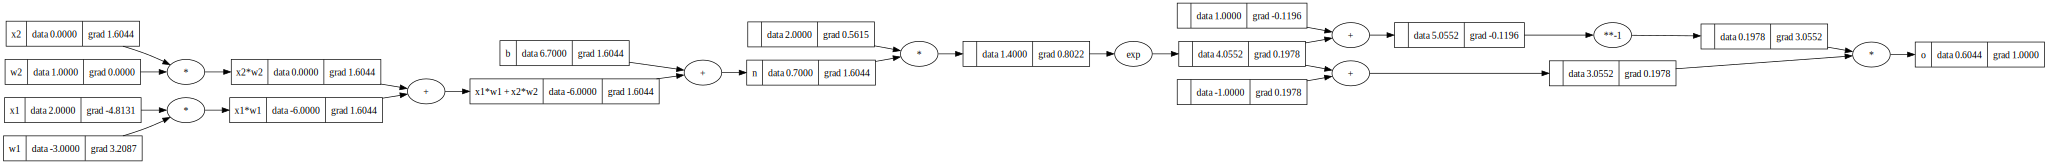

In [35]:
draw_dot(o)

In [93]:
import torch

In [94]:
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad =True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad= True

b = torch.Tensor([6.88137358]).double(); requires_grad=True
n = x1*w1 + x2*w2 + b

In [95]:
o = torch.tanh(n)

In [96]:
print(o.data.item())
o.backward()

0.7071066904050358


In [97]:
print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [98]:
o.data.item()

0.7071066904050358

In [117]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    
    def __call__(self, x):
        #w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)),self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    


In [135]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)

Value(data=-0.803129923434861)

In [136]:
len(n.parameters())

41

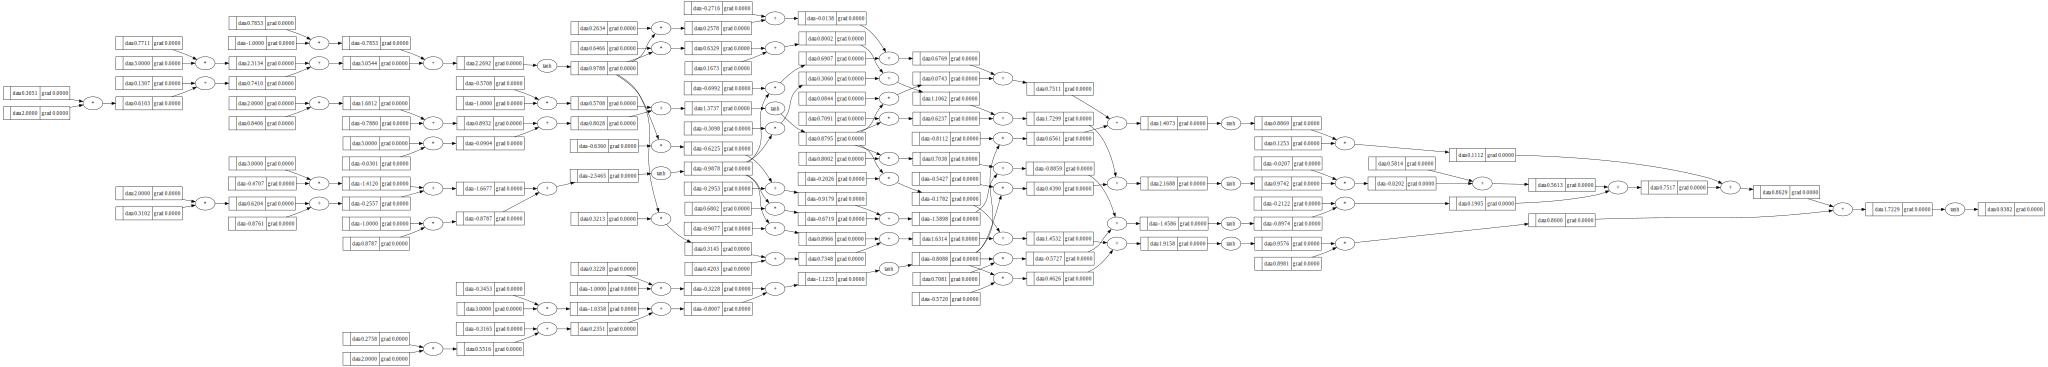

In [100]:
draw_dot(n(x))

In [137]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0] #desired targets

ypred = [n(x) for x in xs]

In [138]:
ypred

[Value(data=-0.803129923434861),
 Value(data=-0.8393017136946807),
 Value(data=-0.5103932420948326),
 Value(data=-0.8155620679299447)]

In [139]:
#for i,y in zip(ys,ypred): print(i,y)

In [140]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=3.5618043391139325)

In [141]:
n.layers[0].neurons[0].w[0].grad

0.0

In [142]:
for p in n.parameters():
    p.data += -0.01 * p.grad 
    

In [143]:
n.layers[0].neurons[0].w[0].grad

0.0

In [178]:
for k in range(100):
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys,ypred))
    
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    for p in n.parameters():
        p.data += -0.1 * p.grad
        
    print(k, loss.data)

0 0.006919128558050627
1 0.0068688126320482525
2 0.006860149621370166
3 0.006720701095984363
4 0.0066608459657257835
5 0.006534622176932922
6 0.006523264060520008
7 0.006404985988003932
8 0.006395251931530496
9 0.006347220500042275
10 0.006335931602589267
11 0.006289121426825493
12 0.00628224867661265
13 0.006231715165214568
14 0.006231715165214568
15 0.006220870129663707
16 0.00621149725221072
17 0.006201651363129491
18 0.006201651363129491
19 0.006094857668552502
20 0.006085828823037816
21 0.006047342248472596
22 0.005948102852837913
23 0.005938732192912908
24 0.005929865331252169
25 0.005929865331252169
26 0.005888129136382873
27 0.005878573354901508
28 0.00587035417182976
29 0.005834113405156523
30 0.005828798073433588
31 0.005793159798600339
32 0.005793159798600339
33 0.005793159798600339
34 0.005697338508501749
35 0.005605881907668493
36 0.005521651855862715
37 0.005512929457279487
38 0.005512929457279487
39 0.005512929457279487
40 0.005481902658741577
41 0.005472732490815864
42 

In [179]:
ypred

[Value(data=0.9750934627225322),
 Value(data=-0.9535063442216026),
 Value(data=-0.9662934072047816),
 Value(data=0.9646021854115681)]